#### Importing Libraries

In [32]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os
import random
device = "cuda" if torch.cuda.is_available() else "cpu"

### Getting Ready With Data


In [ ]:
# image_path = Path("/kaggle/input/gender-detection/data")
image_path = Path("data")
train_dir = image_path/"train"
test_dir = image_path/"test"

### Random Image Check


(-0.5, 511.5, 511.5, -0.5)

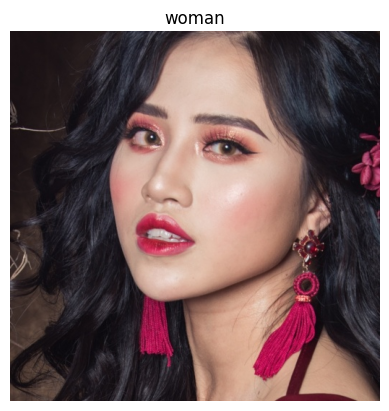

In [34]:

image_list = list(image_path.glob("*/*/*.jpg"))

random_image = random.choice(image_list)

t = random_image.parent.stem
random_image = Image.open(random_image)
plt.imshow(random_image)
plt.title(t)
plt.axis("off")

### Changing the image to Tensor

In [35]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


# data_transform = transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.TrivialAugmentWide(31),
#     transforms.ToTensor()
# ])


### Checking the transform on random image

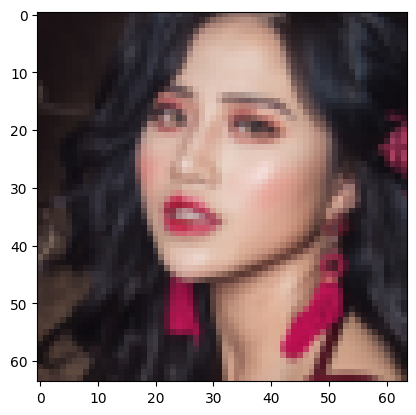

In [36]:
img_t = data_transform(random_image)
plt.imshow(img_t.permute(1,2,0))
plt.show()

### Compairing the Normal image with tranform image

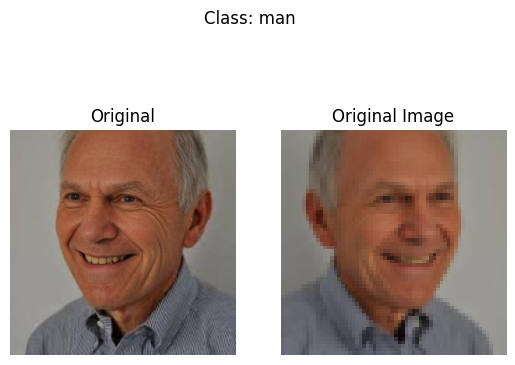

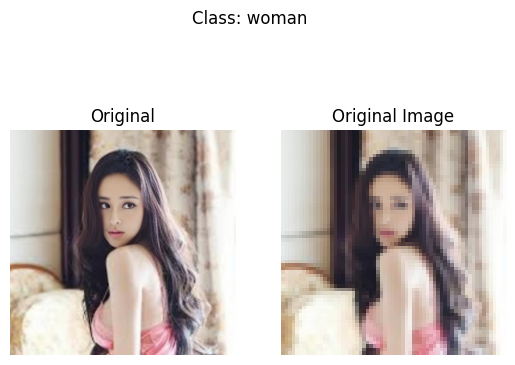

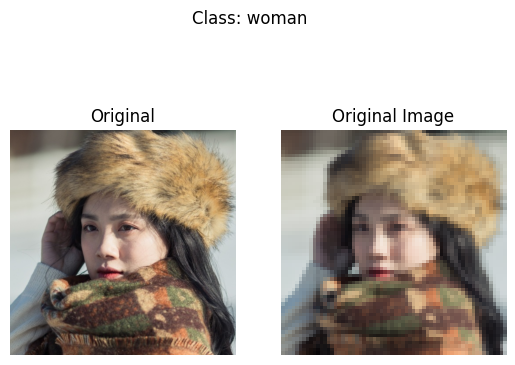

In [37]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Original Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(image_list,data_transform,3)
# random_image

### Creating Dataset 

(-0.5, 63.5, 63.5, -0.5)

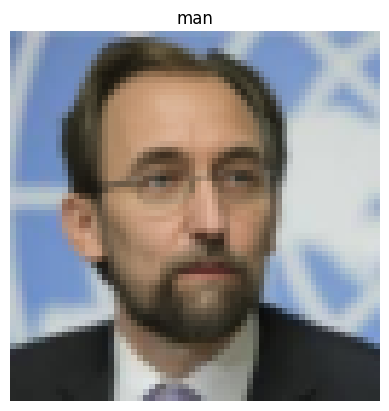

In [38]:
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)


class_name = train_data.classes
img, label = train_data[0][0], train_data[0][1]

plt.imshow(img.permute(1,2,0))
plt.title(class_name[label])
plt.axis("off")

### Creating Dataloder for the model

In [39]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              shuffle=False,
                              num_workers=os.cpu_count())

len(train_dataloader),len(test_dataloader)

(389, 49)

### Train function

In [47]:
 #? Train step()

def train_step(model,dataloader,loss_fn,optimizer):
    model.train()

    # Setup train loss and acc

    train_loss, train_acc = 0,0;

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred,y)

        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #calc acc
        if(batch+1) % 100 == 0:
            print(f"Batch: {batch+1} | "
                  f"Loss: {loss.item():.4f} | "
                  f"Train acc: {train_acc:.4f}")
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    tran_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss,train_acc

 #? Test step()

def test_step(model, dataloader, loss_fn):
    model.eval()

    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=5, device="cpu"):
    results = {"Train_loss": [],
               "Train_Acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, 
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")
        
        results["Train_loss"].append(train_loss)
        results["Train_Acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results


In [48]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])


class TinyVGG(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifer(self.conv_block_2(self.conv_block_1(x))) #? operator fusion

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_name)).to(device)
model_0

import torch.optim.adam
train_data_simple = datasets.ImageFolder(root=train_dir,
                             transform=train_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                             transform=test_transform)

#? Train dataset into loadert

BATCH_SIZE = 32
NUM_WORK = 16

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORK,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORK,
                                     shuffle=False)

torch.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model_0,train_dataloader,test_dataloader,optimizer,loss_fn,NUM_EPOCHS,device)

end = timer()

print(f"Total time:{end - start_time:.3f}Seconds \n")
model_0_results





  0%|          | 0/5 [00:00<?, ?it/s]

Batch: 100 | Loss: 0.5122 | Train acc: 59.9062
Batch: 200 | Loss: 0.4296 | Train acc: 136.7812
Batch: 300 | Loss: 0.4295 | Train acc: 215.7500
Epoch: 1 | train_loss: 201.9422 | train_acc: 0.7330 | test_loss: 0.4439 | test_acc: 0.7967
Batch: 100 | Loss: 0.3852 | Train acc: 79.2812
Batch: 200 | Loss: 0.3508 | Train acc: 159.0625
Batch: 300 | Loss: 0.3905 | Train acc: 241.0938
Epoch: 2 | train_loss: 163.0544 | train_acc: 0.8104 | test_loss: 0.4176 | test_acc: 0.8010
Batch: 100 | Loss: 0.2911 | Train acc: 80.5312
Batch: 200 | Loss: 0.4902 | Train acc: 161.7812
Batch: 300 | Loss: 0.2828 | Train acc: 245.0938
Epoch: 3 | train_loss: 150.9035 | train_acc: 0.8241 | test_loss: 0.3752 | test_acc: 0.8323
Batch: 100 | Loss: 0.3803 | Train acc: 82.2812
Batch: 200 | Loss: 0.2074 | Train acc: 165.9688
Batch: 300 | Loss: 0.2887 | Train acc: 249.7812
Epoch: 4 | train_loss: 140.8453 | train_acc: 0.8377 | test_loss: 0.3464 | test_acc: 0.8425
Batch: 100 | Loss: 0.3475 | Train acc: 83.9062
Batch: 200 | Loss

{'Train_loss': [201.9422274529934,
  163.05439753830433,
  150.90350364148617,
  140.84525924921036,
  129.45004608482122],
 'Train_Acc': [0.7330012853470437,
  0.8103631105398458,
  0.8240841902313625,
  0.8377410025706942,
  0.8529241645244217],
 'test_loss': [0.4439433715781387,
  0.41760718024202753,
  0.37522083718557747,
  0.34643437325650334,
  0.3234528680236972],
 'test_acc': [0.7966978458049886,
  0.8010204081632653,
  0.8322704081632653,
  0.8424744897959183,
  0.8660714285714286]}

### Plotting Loss Curves of the Model


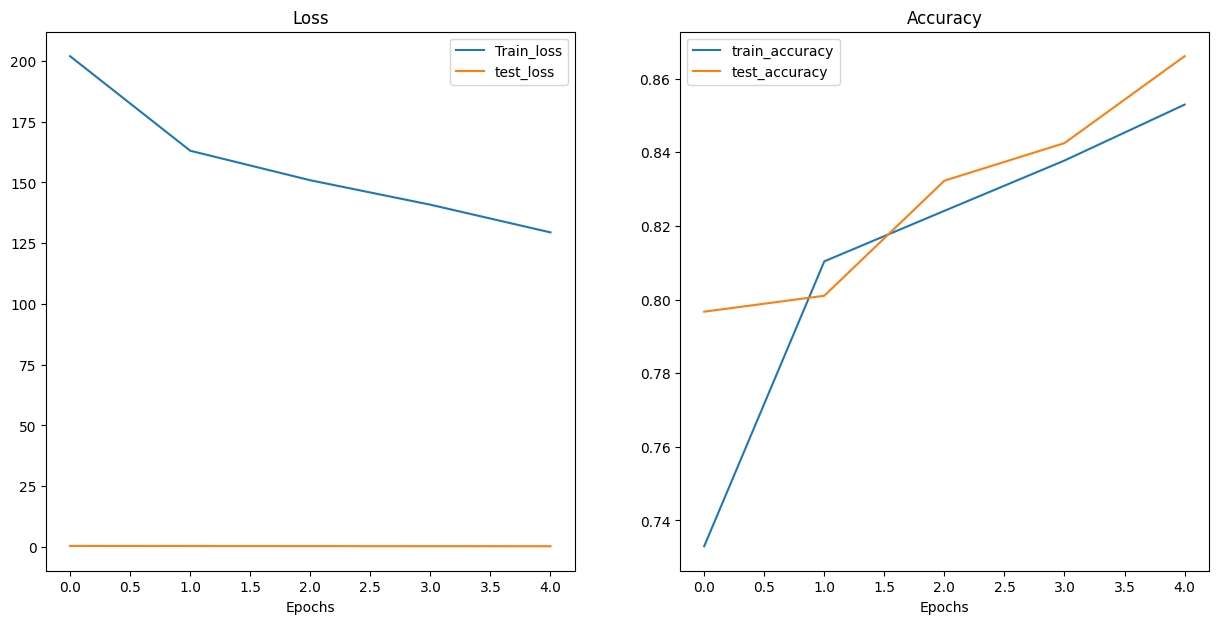

In [49]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    
    Args:
        results (dict): Dictionary containing lists of values, specifically:
            - train_loss
            - train_acc
            - test_loss
            - test_acc
    """
    loss = results['Train_loss']
    test_loss = results['test_loss']

    accuracy = results['Train_Acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['Train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plot_loss_curves(model_0_results)

### Saving the model


In [21]:
import os
if not os.path.exists('model'):
    os.makedirs('model')

torch.save(model_0.state_dict(), 'model/model_0.pth')
print("Model saved successfully to 'model/model_0.pth'")

### Predecting random images with the model

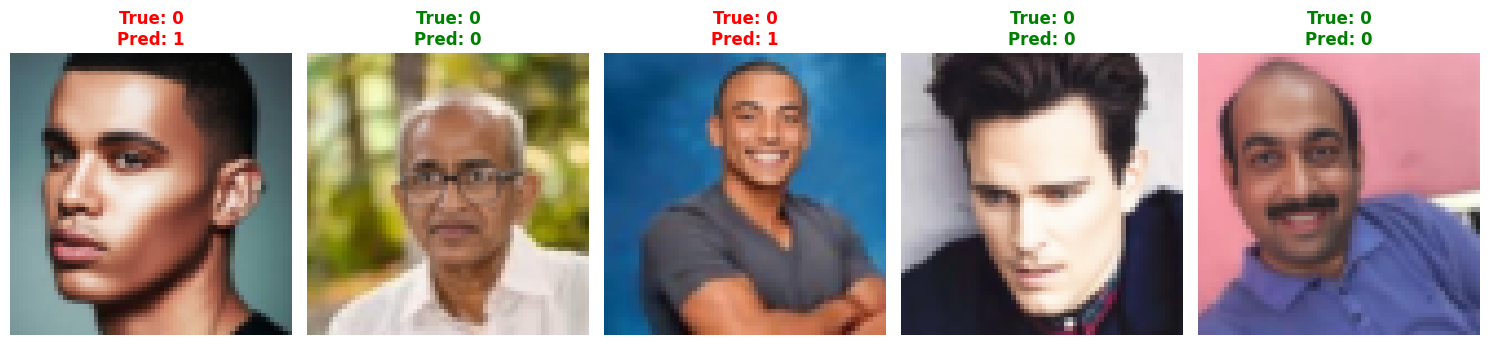

In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    random_images = test_images[random_indices]
    random_labels = test_labels[random_indices]
    
    return random_images, random_labels

model_0.eval()

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)

with torch.no_grad():
    random_images = random_images.to(next(model_0.parameters()).device)
    
    pred_logits = model_0(random_images)
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(15, 10))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, pred_labels)):
    plt.subplot(1, 5, i+1)
    img = image.permute(1, 2, 0).numpy()
    
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.imshow(img)
    
    correct = true_label.item() == pred_label.item()
    color = 'green' if correct else 'red'
    
    plt.title(f"True: {true_label.item()}\nPred: {pred_label.item()}", 
              color=color, fontweight='bold')
    
    if not correct:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.axis("off")
plt.tight_layout()
plt.show()


In [51]:
from torchinfo import summary

summary(model_0,input_size=[1,3,64,64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [52]:
rand_path = Path("Random")

random_set_image = [rand_path / "1.jpg", rand_path / "2.jpg", rand_path / "3.jpg", rand_path / "4.jpg", rand_path / "5.jpg", rand_path / "6.jpg"]

import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

def test_random_images(model, image_paths, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    plt.figure(figsize=(15, 10))
    
    for i, img_path in enumerate(image_paths):
        try:
            image = Image.open(img_path)
            image_tensor = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(image_tensor)
                _, predicted = torch.max(output, 1)
                
            plt.subplot(2, 3, i+1)
            img_display = np.array(image)
            plt.imshow(img_display)
            plt.title(f"Predicted: {'Male' if predicted.item() == 0 else 'Female'}", 
                     fontweight='bold')
            plt.axis("off")
            
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

test_random_images(model_0, random_set_image)


Error processing image Random/1.jpg: [Errno 2] No such file or directory: '/kaggle/working/Random/1.jpg'
Error processing image Random/2.jpg: [Errno 2] No such file or directory: '/kaggle/working/Random/2.jpg'
Error processing image Random/3.jpg: [Errno 2] No such file or directory: '/kaggle/working/Random/3.jpg'
Error processing image Random/4.jpg: [Errno 2] No such file or directory: '/kaggle/working/Random/4.jpg'
Error processing image Random/5.jpg: [Errno 2] No such file or directory: '/kaggle/working/Random/5.jpg'
Error processing image Random/6.jpg: [Errno 2] No such file or directory: '/kaggle/working/Random/6.jpg'


<Figure size 1500x1000 with 0 Axes>


### Finne Tunnin the Vit Model

In [53]:
from transformers import ViTForImageClassification
from timeit import default_timer as timer
device = "cuda" if torch.cuda.is_available() else "cpu"

model_2 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k",num_labels=2).to(device)

#checking is system have multiple cuda Gpus

if torch.cuda.device_count() > 1:
    model_2 = nn.DataParallel(model_2)
    print(f"Using {torch.cuda.device_count()} GPUs")
    
model_2.to(device)

#freezing all the layers except the classisfer layer 
classifier = model_2.module.classifier if hasattr(model_2, 'module') else model_2.classifier

for param in model_2.parameters():
    param.requires_grad = False
for param in classifier.parameters():
    param.requires_grad = True

data_transform_vit = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs


### Creating dataset and datalaoder for it 

In [72]:
train_data_vit = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform_vit,
                                 target_transform=None)
test_data_vit = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform_vit,
                                 target_transform=None)
train_dataloader_vit = DataLoader(dataset=train_data_vit,
                                     batch_size=32,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)
test_dataloader_vit = DataLoader(dataset=test_data_vit,
                                     batch_size=32,
                                     num_workers=os.cpu_count(),
                                     shuffle=False)

optimizer = torch.optim.Adam(model_2.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
start_time = timer()
# Training Variables

train_loss_model2 = []
train_acc_model2 = []
test_loss_model2 = []
test_acc_model2 = []

EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_2.train()

    train_loss_epoch = 0
    train_acc_epoch = 0

    for batch_idx, (X, y) in enumerate(train_dataloader_vit):  
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_2(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc

        if batch_idx % 80 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")
            
    train_loss_epoch /= len(train_dataloader_vit)
    train_acc_epoch /= len(train_dataloader_vit)
    train_loss_model2.append(train_loss_epoch)
    train_acc_model2.append(train_acc_epoch)

    # Evaluation
    model_2.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0

    with torch.inference_mode():
        for X, y in test_dataloader_vit:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_2(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc

    test_loss_epoch /= len(test_dataloader_vit)
    test_acc_epoch /= len(test_dataloader_vit)
    test_loss_model2.append(test_loss_epoch)
    test_acc_model2.append(test_acc_epoch)

    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")

model_2_results = {"Train_loss":train_loss_model2,
                 "test_loss":test_loss_model2,
                 "Train_Acc":train_acc_model2,
                 "test_acc":test_acc_model2}
end = timer()
print(f"Total time:{end - start_time:.3f}Seconds \n")

  0%|          | 0/5 [00:00<?, ?it/s]

1/5.........
Batch 0 | Train loss: 0.05673 | Train acc: 0.97
Batch 80 | Train loss: 0.02256 | Train acc: 1.00
Batch 160 | Train loss: 0.08519 | Train acc: 1.00
Batch 240 | Train loss: 0.07238 | Train acc: 0.97
Batch 320 | Train loss: 0.14898 | Train acc: 0.94
Train loss: 0.07072 | Train acc: 0.98 | Test loss: 0.07611 | Test acc: 0.97
2/5.........
Batch 0 | Train loss: 0.02280 | Train acc: 1.00
Batch 80 | Train loss: 0.19345 | Train acc: 0.91
Batch 160 | Train loss: 0.09505 | Train acc: 0.97
Batch 240 | Train loss: 0.03194 | Train acc: 1.00
Batch 320 | Train loss: 0.15416 | Train acc: 0.94
Train loss: 0.07332 | Train acc: 0.97 | Test loss: 0.05821 | Test acc: 0.98
3/5.........
Batch 0 | Train loss: 0.13750 | Train acc: 0.97
Batch 80 | Train loss: 0.01752 | Train acc: 1.00
Batch 160 | Train loss: 0.05241 | Train acc: 0.97
Batch 240 | Train loss: 0.03081 | Train acc: 1.00
Batch 320 | Train loss: 0.02801 | Train acc: 1.00
Train loss: 0.07028 | Train acc: 0.98 | Test loss: 0.06434 | Test ac

### PLotting Graph

In [73]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    train_losses = results["Train_loss"]
    val_losses = results["test_loss"]
    train_accs = results["Train_Acc"]
    val_accs = results["test_acc"]

    steps_train = list(range(1, len(train_losses) + 1))
    steps_val = list(range(1, len(val_losses) + 1))

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps_train, train_losses, label='Train Loss')
    plt.plot(steps_val, val_losses, label='Val Loss')
    plt.title('Loss Over Batches')
    plt.xlabel('Batch Step')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(steps_train, train_accs, label='Train Accuracy')
    plt.plot(steps_val, val_accs, label='Val Accuracy')
    plt.title('Accuracy Over Batches')
    plt.xlabel('Batch Step')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


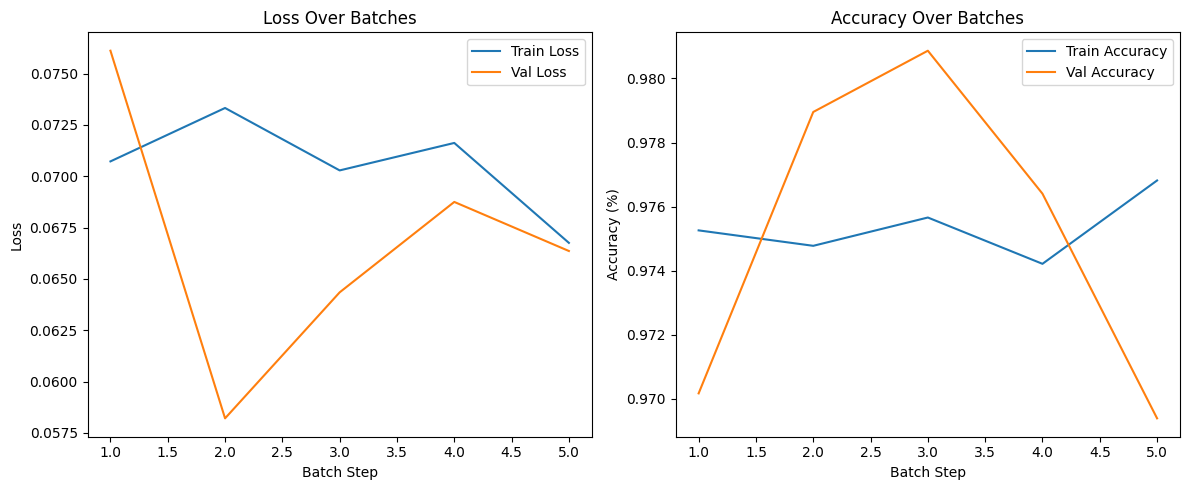

In [74]:

plot_loss_curves(model_2_results)


### Saving the Model

In [ ]:
torch.save(model_0.state_dict(), 'model/model.pth')
print("Model saved successfully to 'model/model.pth'")

### Predict Random

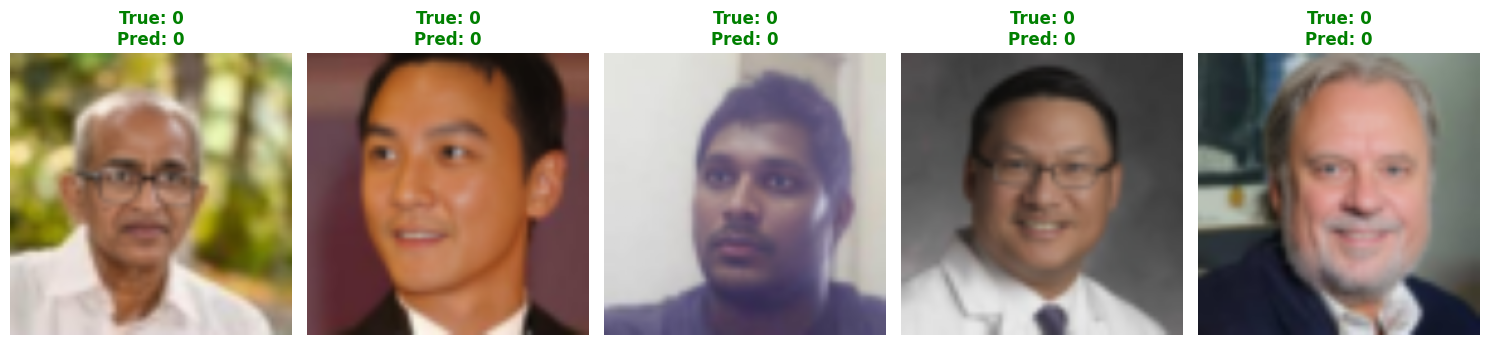

In [80]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    random_images = test_images[random_indices]
    random_labels = test_labels[random_indices]
    resize_transform = transforms.Resize((224, 224))
    random_images = torch.stack([resize_transform(img) for img in random_images])
    return random_images, random_labels

model_2.eval()

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)

with torch.no_grad():
    random_images = random_images.to(next(model_2.parameters()).device)
    
    pred_logits = model_2(random_images).logits
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(15, 10))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, pred_labels)):
    plt.subplot(1, 5, i+1)
    img = image.permute(1, 2, 0).numpy()
    
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.imshow(img)
    
    correct = true_label.item() == pred_label.item()
    color = 'green' if correct else 'red'
    
    plt.title(f"True: {true_label.item()}\nPred: {pred_label.item()}", 
              color=color, fontweight='bold')
    
    if not correct:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.axis("off")
plt.tight_layout()
plt.show()
_ = get_random_test_samples(test_dataloader_vit, num_samples=10)